In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from scipy.integrate import quad
import gdown
from IPython.display import clear_output as clc

In [2]:
try:
     from dlroms import*
except:
     !pip install git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

# DeepONet

**DeepONet** is a neural network designed to learn non linear operator (mapping between spaces of functions). It's foundations lies in the **universal approximation theorem for operators**, which states that a neural network with a single hidden layer can accurately approximate any nonlinear continuous operator. DeepONets aim to realize this theoretical capability in practice by using deep neural networks. Specifically, the structure of DeepONet with its **branch** and **trunk** networks mirrors the form suggested by

**Theorem 1 (Universal Approximation Theorem for Operators)**
Let $\sigma$ be a continuous non-polynomial function, $X$  Banach space, $K_1 \subset X$, $K_2 \subset \mathbb{R}^d$  two compact sets\* in $X$ and $\mathbb{R}^d$, respectively,  $V$  compact set in $C(K_1)$. Let  $G: V \to C(K_2)$  be a nonlinear continuous operator. Then for any $\epsilon > 0$, there are positive integers $n, p$ and $m$, constants $c_i^k, \xi_{ij}^k, \theta_i^k, \zeta_k \in \mathbb{R}$, $w_k \in \mathbb{R}^d$, $x_j \in K_1$, $i = 1, \ldots, n$, $k = 1, \ldots, p$ and $j = 1, \ldots, m$, such that  

$$
\left| G(u)(y) - \sum_{k=1}^{p} \sum_{i=1}^{n} c_i^k \sigma \left( \sum_{j=1}^{m} \xi_{ij}^k u(x_j) + \theta_i^k \right) \sigma(w_k \cdot y + \zeta_k) \right| < \epsilon
$$

holds for all $u \in V$ and $y \in K_2$.

## Learning operator with DeepONet
Goal is to learn the operator $G$ in an effective way, but the universal approximation theorems only guarantee a small approximation error for a sufficiently large network, not considering the optimization error and generalization error at all, which are equally important and often dominant contributions to the total error in practice\*\*.  Useful networks should be easy to train, i.e., exhibit small optimization error, and generalize well to unseen data, i.e., exhibit small generalization error. Few facts can be exploited to reach the goal:

1. A key idea behind the **Universal Approximation Theorem for Operators** is that an operator acting on a function space can be **reconstructed using a finite number of function values at fixed points**. This allows us to transform an **infinite-dimensional learning problem** into a **finite-dimensional one**, making it computationally feasible. As a consequence, the **sensor locations are operator-dependent** and must remain consistent across all training samples. This means that for any operator $G$, the training dataset must be constructed such that all input functions are sampled at the same fixed sensor points $\{x_1, x_2, \ldots, x_m\}$.  
2.  In practical  implementation, $y$ reduce to a vector with $d$ components, so the dimension of $y$ no longer matches the dimension of $u(x_i)$ for $i = 1, 2, \ldots, m$. This also prevents us from treating $u(x_i)$ and $y$ equally, and thus at least two subnetworks are needed to handle $[u(x_1), u(x_2), \ldots, u(x_m)]^T$ and $y$ separately.
3. The approximation statement in the Universal Approximation Theorem for Operators suggest us to considers a **two shallow network with one hidden layer**. We can extend this with **deep networks** to increase expressivity and improves performance.

The  DeepONet architecture consists of:
- A **trunk network** that takes $y$ as input and outputs a vector $[t_1, t_2, \ldots, t_p]^T \in \mathbb{R}^p$.
- p **branch networks**, each taking $[u(x_1), u(x_2), \ldots, u(x_m)]^T$ as input and producing a scalar $b_k$ for $k=1,...,p$.
- The final output is computed as:
$$
G(u)(y) \approx \sum_{k=1}^{p} b_k t_k.
$$
In practice, $p$ is at least of the order of 10, and using lots of branch networks is computationally and memory expensive. Hence, we merge all the branch networks into one single branch network , i.e., a single branch network outputs a vector $[b_1, b_2, \ldots, b_p]^T \in \mathbb{R}^p$.
![[Pasted image 20250402125959.png]]
A similar approximation result for the constructed network can be proved:

**Theorem 2 (Generalized Universal Approximation Theorem for Operator)**
Let $X$  be a Banach space, $K_1 \subset X$, $K_2 \subset \mathbb{R}^d$  two compact sets in $X$ and $\mathbb{R}^d$, respectively,  $V$  compact set in $C(K_1)$. Let  $G: V \to C(K_2)$  be a nonlinear continuous operator. Then, for any $\varepsilon > 0$, there exist positive integers $m, p$, continuous vector functions $g: \mathbb{R}^m \to \mathbb{R}^p$, $f: \mathbb{R}^d \to \mathbb{R}^p$, and $x_1, x_2, \dots, x_m \in K_1$, such that  

$$
\left| G(u)(y) - \underbrace{\langle g(u(x_1), u(x_2), \cdots, u(x_m)), f(y) \rangle}_{\text{branch}} \right| < \varepsilon
$$

holds for all $u \in V$ and $y \in K_2$, where $\langle \cdot, \cdot \rangle$ denotes the dot product in $\mathbb{R}^p$. Furthermore, the functions $g$ and $f$ can be chosen as diverse classes of neural networks, which satisfy the classical universal approximation theorem of functions, for example, (stacked/unstacked) fully connected neural networks, residual neural networks and convolutional neural networks.

----
\*Note that the theorem require the compactness of the function space. In fact, the function space like $C([0,1])$ is “too large” for real applications, so it is suitable to consider a smaller space with compactness property.

\*\*Consider the classical image classification task as an example. The universal approximation theorem of neural networks for functions shows that fully-connected neural networks (FNNs) are capable to approximate the ground-truth classification function accurately, but in practice the performance of FNNs is far from networks with specific architectures, such as the widely-used convolutional neural networks (CNN). The performance gap lies in the fact that the accuracy of NNs can be characterized by dividing the total error into three main types: approximation, optimization, and generalization.

![img](https://media.springernature.com/m685/springer-static/image/art%3A10.1038%2Fs42256-021-00302-5/MediaObjects/42256_2021_302_Fig1_HTML.png)

## Practical consideration
In applications the operator of interest is often the form
$$\boldsymbol{\mu}\mapsto u_{\boldsymbol{\mu}},$$
where a the input parameters, $\boldsymbol{\mu}$, is mapped onto some function $u_{\boldsymbol{\mu}}:\Omega\to\mathbb{R}$ defined on a suitable spatial domain $\Omega\subset\mathbb{R}^{2}$. We can think, for instance, as $\boldsymbol{\mu}$ being the parameters of a PDE and $u_{\boldsymbol{\mu}}$ as its corresponding solution. Essentially, the idea of DeepONets is to approximate this map by directly prescribing the parametrized output $u=u(\boldsymbol{\mu},\boldsymbol{y})$ through a separation of variables approach. That is, for every $\boldsymbol{\mu}$ in the parameter space and every $\boldsymbol{y}$ in the spatial domain, one writes
$$u_{\boldsymbol{\mu}}(\boldsymbol{y})=u(\boldsymbol{\mu},\boldsymbol{y})\approx \sum_{i=1}^{p}\xi_i(\boldsymbol{y})\phi_i(\boldsymbol{\mu}),$$
and proceeds by learning the maps $\xi_1,\dots,\xi_p$ and $\phi_1,\dots,\phi_p$  through two multi-valued network
$$\xi:\mathbb{R}^{m}\to\mathbb{R}^{p}\quad\text{and}\quad\phi:\mathbb{R}^{d}\to\mathbb{R}^{p}$$
such that
$$u_{\boldsymbol{\mu}}(\boldsymbol{y})=u(\boldsymbol{\mu},\boldsymbol{y})\approx \xi(\boldsymbol{y})\cdot\phi(\boldsymbol{\mu})$$

## Optimization

Training phase is typically supervised, minimizing a mean square error loss function
$$
\mathcal{L} = \frac{1}{N} \sum_{i=1}^{N} \sum_{j=1}^{D} \left| G_{\theta}(u_i)(y_j) - G(u_i)(y_j) \right|^2
$$

where:
- $ G_{\theta}(u_i)(y_j) $ is the DeepONet's predicted output at spatial location $ y_j $,
- $ G(u_i)(y_j)$ is the ground truth function value,
- $ N $ is the number of training samples (input functions $ u_i $),
- $ D $ is the number of evaluation points $ y_j $ in the output domain.


# Implementation

In [3]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [4]:
class DeepONet(nn.Module):
  def __init__(self, m, d, p, h):
      """
      Parameters
      ----------
      m : int
          dimension for the input parameters
      d : int
          dimension for the input data
      p : int
          dimension of branch and trunk networks output
      h : int
          number of neurons in hidden layers
      """
      super().__init__()

      self.branch = nn.Sequential(
          nn.Linear(m, h),
          nn.LeakyReLU(),
          nn.Linear(h, h),
          nn.LeakyReLU(),
          nn.Linear(h, p)
      )
      self.trunk = nn.Sequential(
          nn.Linear(d, h),
          nn.LeakyReLU(),
          nn.Linear(h, h),
          nn.LeakyReLU(),
          nn.Linear(h, p)
      )

  def forward(self, u, y):
      b = self.branch(u)  # Shape: (batch_size, p)
      b = b.unsqueeze(1)  # New shape: (batch_size, 1, p)
      t = self.trunk(y)   # Shape: (batch_size, 1681, p)

      #print(f"b.shape: {b.shape}, t.shape: {t.shape}")

      Gu = torch.sum(b * t, dim=-1) # Shape: (batch_size, 1681)
      #print(f"Gu.shape: {Gu.shape}")

      return Gu

## Utilities

In [5]:
# Data
class FomDataset(Dataset):
  def __init__(self, mu, u, y):
    """
    Parameters
    ----------
    mu : int
    input parameters, referred as u in the DeepONet paper and in the above model
    u : int
    solution of the PDE, referred as G(u) in the DeepONet paper and in the above model
    y : int
    spatial domain coordinate, referred as y in the DeepONet paper and in the above model
    """
    self.mu = torch.tensor(mu, dtype=torch.float32)
    self.u = torch.tensor(u, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
    return len(self.mu)

  def __getitem__(self, idx):
    return self.mu[idx], self.u[idx], self.y

def train_val_test_split(dataset, train_size, val_size):
    """
    Splits a dataset into training, validation, and test subsets.

    Parameters
    ----------
    dataset : FomDataset
        The full dataset.
    train_size : int
        Total number of training samples (includes validation).
    val_size : int
        Number of validation samples.
    """
    train_indices = list(range(0, train_size - val_size))
    val_indices = list(range(train_size - val_size, train_size))
    test_indices = list(range(train_size, len(dataset)))

    train_set = Subset(dataset, train_indices)
    val_set = Subset(dataset, val_indices)
    test_set = Subset(dataset, test_indices)

    return train_set, val_set, test_set

In [6]:
def load_data(id):
  gdown.download(id = id, output = "data.npz")
  data = np.load("data.npz")
  mu, u = data['mu'].copy(), data['u'].copy()
  return mu, u

def get_fem_space(custom_mesh = None):
  if custom_mesh is None:
    mesh = fe.unitsquaremesh(40, 40)
  else:
    mesh = custom_mesh
  Vh = fe.space(mesh, 'CG', 1)
  y = fe.coordinates(Vh)
  return Vh, y

In [7]:
# Training
class Trainer:
  def __init__(self, train_loader, val_loader, test_loader, model, loss_function, optimizer, epochs, error_metric = None, verbose=False):
    self.train_loader = train_loader
    self.val_loader = val_loader
    self.test_loader = test_loader
    self.model = model
    self.loss_function = loss_function
    self.error_metric = error_metric
    self.optimizer = optimizer
    self.epochs = epochs
    self.verbose = verbose

    self.train_hist = {"loss": [], "error_metric": []}
    self.val_hist = {"loss": [], "error_metric": []}
    self.test_hist = {"loss": [], "error_metric": []}


  def train_step(self):
    """
    Perform a single training step in the optimization loop
    """
    train_size = len(self.train_loader.dataset)
    num_batches = len(self.train_loader)
    batch_size =  self.train_loader.batch_size
    total_loss = 0.0  # Accumulate loss for reporting
    total_error_metric = 0.0

    self.model.train()
    for batch_idx, (mu, u, y) in enumerate(self.train_loader):

      # Predict
      Gu_pred = self.model(mu,y)
      loss = self.loss_function(Gu_pred, u) # The optimizer updates weights batch-by-batch in sgd so we don't need to accumolate it for final reporting
      total_loss += loss.item()
      if(self.error_metric is not None):
        metric = self.error_metric(Gu_pred, u)
        total_error_metric += metric.item()

      # Backpropagation
      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      # Print training stats
      if (batch_idx % 10 == 0):
        loss_value, current_sample = loss.item(), batch_idx * batch_size + len(mu)
        print(f"\rCurrent Loss: {loss_value:>7f}  [{current_sample:>5d}/{train_size:>5d}]", end="", flush=True)

    avg_loss = total_loss / num_batches  # Compute average loss for the epoch
    avg_error_metric = total_error_metric / num_batches


    return avg_loss, avg_error_metric # return the avg train loss at the end of the epoch

  def validation_step(self):
    """
    Perform a single validation step in the optimization loop
    """
    num_batches = len(self.val_loader)
    total_loss = 0.0
    total_error_metric = 0.0

    self.model.eval()
    with torch.no_grad():
      for batch_idx, (mu, u, y) in enumerate(self.val_loader):
        #Predict
        Gu_pred = self.model(mu,y)
        loss = self.loss_function(Gu_pred, u)
        total_loss += loss.item()
        if(self.error_metric is not None):
          metric = self.error_metric(Gu_pred, u)
          total_error_metric += metric.item()

      avg_loss = total_loss / num_batches
      avg_error_metric = total_error_metric / num_batches

      return avg_loss, avg_error_metric

  def test_step(self):
    """
    Perform a single test step in the optimization loop
    """
    num_batches = len(self.test_loader)
    total_loss = 0.0
    total_error_metric = 0.0

    self.model.eval()
    with torch.no_grad():
      for batch_idx, (mu, u, y) in enumerate(self.test_loader):
        #Predict
        Gu_pred = self.model(mu,y)
        loss = self.loss_function(Gu_pred, u)
        total_loss += loss.item()
        if(self.error_metric is not None):
          metric = self.error_metric(Gu_pred, u)
          total_error_metric += metric.item()

    avg_loss = total_loss / num_batches
    avg_error_metric = total_error_metric / num_batches

    return avg_loss, avg_error_metric

  def fit(self):
    """
    Perform the optimization loop over the specified number of epochs.
    """
    for epoch in range(self.epochs):
      print(f"Epoch {epoch+1}/{self.epochs}:")

      # Run train, validation, and test steps
      train_loss, train_err_metric = self.train_step()
      val_loss, val_err_metric = self.validation_step()
      test_loss, test_err_metric = self.test_step()

      # Save history
      self.train_hist["loss"].append(train_loss), self.val_hist["loss"].append(val_loss), self.test_hist["loss"].append(test_loss)
      if(self.error_metric is not None):
        self.train_hist["error_metric"].append(train_err_metric), self.val_hist["error_metric"].append(val_err_metric), self.test_hist["error_metric"].append(test_err_metric)

      # Print formatted progress
      print(f"\nTrain Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Test Loss: {test_loss:.4f}")
      if(self.error_metric is not None and self.verbose):
        print(f"Train Error Metric: {train_err_metric:.4f} | Val Error Metric: {val_err_metric:.4f} | Test Error Metric: {test_err_metric:.4f}")

    print("Done!")

    return self.train_hist, self.val_hist, self.test_hist

In [8]:
# Loss and Metric definitions
def mse_loss(true, predicted):
  return (true-predicted).pow(2).mean(axis = -1).mean()

def error_metric(true, predicted):
  return ((true-predicted).abs().mean(axis = -1)/true.abs().mean(axis = -1)).mean()

In [9]:
# Plotting utilities
def plot_errors(trainer, ymax_loss, ymax_metric):
    n_epochs = trainer.epochs

    # Plot Loss
    plt.figure(figsize=(10, 4))  # Wider figure for side-by-side plots

    plt.subplot(1, 2, 1)
    train_loss = trainer.train_hist['loss']
    val_loss = trainer.val_hist['loss']
    test_loss = trainer.test_hist['loss']
    plt.semilogx(train_loss, '-k', label='Train')
    plt.semilogx(val_loss, '--b', label='Validation')
    plt.semilogx(test_loss, '--r', label='Test')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.axis([0.5, n_epochs, 0, ymax_loss])
    plt.legend()

    # Plot Error Metric if available
    if trainer.error_metric is not None:
        plt.subplot(1, 2, 2)
        train_metric = trainer.train_hist['error_metric']
        val_metric = trainer.val_hist['error_metric']
        test_metric = trainer.test_hist['error_metric']
        plt.semilogx(train_metric, '-k', label='Train')
        plt.semilogx(val_metric, '--b', label='Validation')
        plt.semilogx(test_metric, '--r', label='Test')
        plt.xlabel('Epochs')
        plt.ylabel('MRE')
        plt.title('Error Metric')
        plt.axis([0.5, n_epochs, 0, ymax_metric])
        plt.legend()

    plt.tight_layout()
    plt.show()

In [10]:
def plot_solution(mu, u, Vh):
  clc()
  fe.plot(u, Vh)
  plt.title("Solution for $\mu$ = [%.2f,%.2f,%.2f]" % tuple(mu))
  None

def add_batch_dimension(test_sample):
    # Add batch dimension to the test_sample
    mu, true_u, y = test_sample
    mu = mu.unsqueeze(0)
    true_u = true_u.unsqueeze(0)
    y = y.unsqueeze(0)
    return mu, true_u, y

def compare_solutions(test_sample, Vh):
    # Add batch dimension
    mu, true_u, y = add_batch_dimension(test_sample)

    # Get the predicted solution
    pred_u = model(mu, y).squeeze(0)  # Remove batch dimension for plotting

    # Ensure the solutions are numpy arrays
    true_u = true_u.squeeze(0).detach().numpy()
    pred_u = pred_u.detach().numpy()

    # Plot the true and predicted solutions
    clc()
    plt.figure(figsize=(10, 5))

    vmin, vmax = true_u.min(), true_u.max()

    plt.subplot(1, 2, 1)
    plt.title("True solution")
    fe.plot(true_u, Vh, colorbar=True, vmin=vmin, vmax=vmax, shrink=0.7)

    plt.subplot(1, 2, 2)
    plt.title("DeepONet approximation")
    fe.plot(pred_u, Vh, colorbar=True, vmin=vmin, vmax=vmax, shrink=0.7)

    plt.show()

In [11]:
def compare_solutions_scalar(test_sample):
  # Add batch dimension
  mu, true_u, y = add_batch_dimension(test_sample)

  # Get the predicted solution
  pred_u = model(mu, y).squeeze(0)  # Remove batch dimension for plotting

  # Ensure the solutions are numpy arrays
  true_u = true_u.squeeze(0).detach().numpy()
  pred_u = pred_u.detach().numpy()

  # Plot the true and predicted solutions
  clc()
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.plot(xsens, mu.squeeze(0), '.', label = 'sensors')
  plt.title("Input $f$")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(ygrid, true_u, color = 'orange', label = 'True')
  plt.plot(ygrid, pred_u, '--r', label = 'DeepONet')
  plt.title("Output $u$")
  plt.legend()
  None

# Test


# Tests

## 1. Poisson Equation (finite-dimensional parameter)

Consider the following Poisson equation

$$\begin{cases}
-\sigma\Delta u(\boldsymbol{x}) = \gamma\sin(4x_1x_2) + (1-\gamma)\cos(x_1-8x_2) & \boldsymbol{x}\in\Omega\\\\
u(\boldsymbol{x})= b & \boldsymbol{x}\in\Gamma\\\\
-\nabla u(\boldsymbol{x})\cdot \boldsymbol{n}=0 & \boldsymbol{x}\in\partial\Omega\setminus\Gamma
\end{cases}$$
$$$$

where $\Omega=(0,1)^2$ is the unit square and $\Gamma=\{(0,x_2)\;:\;0\le x_2\le1\}$ is the left edge. The PDE parameters are $\boldsymbol{\mu}=[\sigma,b,\gamma]$, with $\sigma\in[0.1,1]$, $b\in[0,2]$ and $\gamma\in[0,1]$. In particular, $p=3$.

A set of PDE solutions has using numerical solver been computed and available.


In [12]:
# Retrieve the data
mu, u = load_data(id = "1c9jCfgzie74vfhVgZueKySIZv9AHXng_")
Vh, y = get_fem_space()

Downloading...
From: https://drive.google.com/uc?id=1c9jCfgzie74vfhVgZueKySIZv9AHXng_
To: /content/data.npz
100%|██████████| 6.74M/6.74M [00:00<00:00, 48.6MB/s]

Calling FFC just-in-time (JIT) compiler, this may take some time.



Level 25:FFC:Calling FFC just-in-time (JIT) compiler, this may take some time.
INFO:FFC:Compiling element ffc_element_3801828c0f66b7190a7fd5819465b3d5b34b9149

INFO:FFC:Compiler stage 1: Analyzing element(s)
INFO:FFC:--------------------------------------
INFO:FFC:  
INFO:FFC:Compiler stage 1 finished in 0.00455546 seconds.

INFO:FFC:Compiler stage 2: Computing intermediate representation
INFO:FFC:-------------------------------------------------------
INFO:FFC:  Computing representation of 1 elements
DEBUG:FFC:  Reusing element from cache
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 1 dofmaps
DEBUG:FFC:  Reusing element from cache
INFO:FFC:  Computing representation of 0 coordinate mappings
INFO:FFC:  Computing representation of integrals
INFO:FFC:  Computing representation of forms
INFO:FFC:  
INFO:FFC:Compiler stage 2 finished in 0.264692 seconds.

INFO:FFC:Compiler stage 3: Optimizing intermediate representation
INFO:FFC:---------------------------

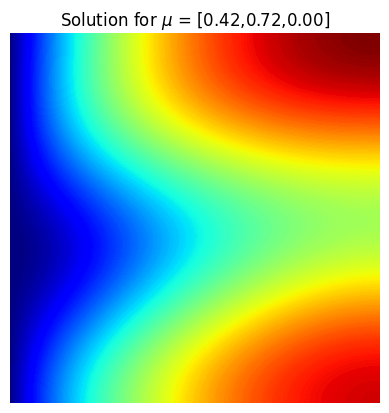

In [13]:
plot_solution(mu[1], u[1], Vh)

In [14]:
mu.shape, u.shape, y.shape

((500, 3), (500, 1681), (1681, 2))

In [15]:
# Config
learning_rate = 1e-3
batch_size = 1
epochs = 50

m = mu.shape[1]
d = y.shape[1]
p = 15
h = 40

In [16]:
# Build the model
model = DeepONet(m,d,p,h)
model.to(device)
print(model)

DeepONet(
  (branch): Sequential(
    (0): Linear(in_features=3, out_features=40, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=40, out_features=15, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=2, out_features=40, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=40, out_features=15, bias=True)
  )
)


In [17]:
# Build the dataset
train_size = int(0.8 * len(mu))
val_size = int(0.1 * train_size)

dataset = FomDataset(mu, u, y)
train_set, val_set, test_set = train_val_test_split(dataset, train_size, val_size)

train_loader = DataLoader(train_set, batch_size = batch_size)
val_loader = DataLoader(val_set, batch_size = batch_size)
test_loader =  DataLoader(test_set, batch_size = batch_size)

In [18]:
# Define loss function
loss_function = mse_loss
error_metric = error_metric

# Define optimization strategy
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [19]:
# Train the model
trainer = Trainer(train_loader, val_loader, test_loader, model, loss_function, optimizer, epochs, error_metric)
train_hist, val_hist, test_hist = trainer.fit()

Epoch 1/50:
Current Loss: 0.027855  [  351/  360]
Train Loss: 0.2342 | Val Loss: 0.0405 | Test Loss: 0.0562
Epoch 2/50:
Current Loss: 0.005625  [  351/  360]
Train Loss: 0.0363 | Val Loss: 0.0374 | Test Loss: 0.0518
Epoch 3/50:
Current Loss: 0.001884  [  351/  360]
Train Loss: 0.0287 | Val Loss: 0.0305 | Test Loss: 0.0430
Epoch 4/50:
Current Loss: 0.002135  [  351/  360]
Train Loss: 0.0214 | Val Loss: 0.0257 | Test Loss: 0.0386
Epoch 5/50:
Current Loss: 0.001276  [  351/  360]
Train Loss: 0.0155 | Val Loss: 0.0182 | Test Loss: 0.0298
Epoch 6/50:
Current Loss: 0.000917  [  351/  360]
Train Loss: 0.0086 | Val Loss: 0.0106 | Test Loss: 0.0195
Epoch 7/50:
Current Loss: 0.002862  [  351/  360]
Train Loss: 0.0057 | Val Loss: 0.0062 | Test Loss: 0.0127
Epoch 8/50:
Current Loss: 0.005388  [  351/  360]
Train Loss: 0.0047 | Val Loss: 0.0051 | Test Loss: 0.0108
Epoch 9/50:
Current Loss: 0.005252  [  351/  360]
Train Loss: 0.0044 | Val Loss: 0.0045 | Test Loss: 0.0101
Epoch 10/50:
Current Loss: 0

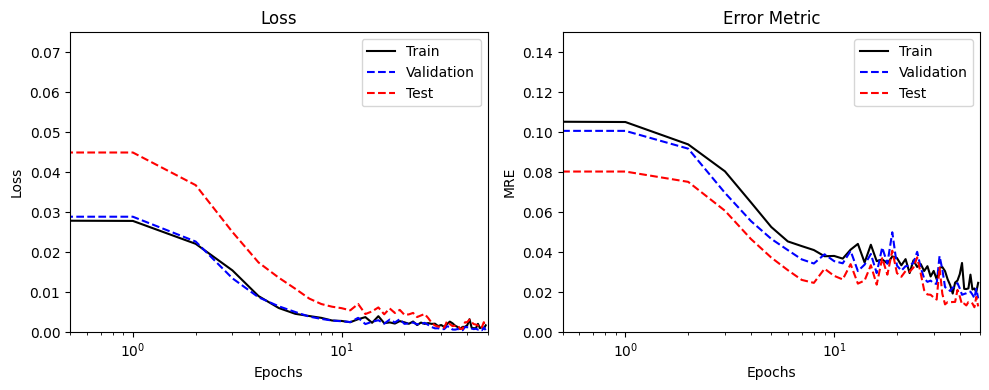

In [ ]:
plot_errors(trainer, 0.06, 0.014)

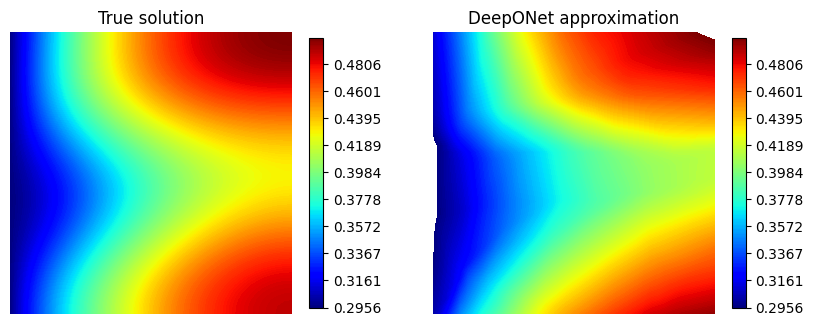

In [ ]:
j = -10
compare_solutions(test_set[j], Vh)

In [20]:
print("MRE for DeepONet: %s." % num2p(trainer.train_hist['error_metric'][-1]))

MRE for DeepONet: 3.03%.


## 2. Function-to-function

Consider the following nonlinear operator $G$ mapping 1D functions onto 1D functions acting as

$$G:\quad f(y)\mapsto \int_{0}^{x}\frac{1}{1+f(2s)^2}ds,$$

where $f=f(y)$ is defined for $y\in[0,1]$, whereas the output $u=u(x)$ is defined for $x\in[0,1/2]$.

In order to sample a collection of possible "input signals" we use an auxiliary Gaussian process $Z:[0,1]\to\mathbb{R}$ whose realizations are of the form

$$Z(y)=\sum_{j=1}^{100}e^{-j} \eta_j \sin(\pi j y),$$

with $\eta_1,\dots,\eta_{100}$ i.i.d. $\mathcal{N}(0,1)$.

In [21]:
def G(f):
  integrand = lambda s: 1.0/(1.0 + f(2*s)**2)
  return lambda x: quad(integrand, 0, x)[0]

In [22]:
def Z():
  eta = np.random.randn(100)
  j = np.arange(1, 101)
  c = eta*np.exp(-j)
  return lambda y: c @ np.sin(np.pi * j.reshape(-1, 1) * np.array(y).reshape(1, -1))

In [23]:
# Prepare the dataset
ndata = 200
ygrid = np.linspace(0, 0.5, 1000)
xsens = np.linspace(0, 1, 50)

mu = []
u = []

for n in range(ndata):
  clc(wait=True)
  print("Computing sample #%d..." % (n+1))

  np.random.seed(n)
  f = Z()
  mu_new = f(xsens)
  u_new = np.array([G(f)(y) for y in ygrid])

  mu.append(mu_new)
  u.append(u_new)

clc()

mu = np.stack(mu, axis = 0)
u = np.stack(u, axis = 0)

In [24]:
y = ygrid.reshape(-1, 1)

In [25]:
mu.shape, u.shape, y.shape

((200, 50), (200, 1000), (1000, 1))

In [26]:
# Config
learning_rate = 1e-4
batch_size = 1
epochs = 50

m = mu.shape[1]
d = y.shape[1]
p = 15
h = 40

In [27]:
# Build the model
model = DeepONet(m,d,p,h)
model.to(device)
print(model)

DeepONet(
  (branch): Sequential(
    (0): Linear(in_features=50, out_features=40, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=40, out_features=15, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=1, out_features=40, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=40, out_features=40, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=40, out_features=15, bias=True)
  )
)


In [28]:
# Build the dataset
train_size = 150
val_size = 50

dataset = FomDataset(mu, u, y)
train_set, val_set, test_set = train_val_test_split(dataset, train_size, val_size)

train_loader = DataLoader(train_set, batch_size = batch_size)
val_loader = DataLoader(val_set, batch_size = batch_size)
test_loader =  DataLoader(test_set, batch_size = batch_size)

In [29]:
train_size, val_size

(150, 50)

In [30]:
# Define loss function
loss_function = mse_loss
error_metric = error_metric

# Define optimization strategy
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [31]:
# Train the model
trainer = Trainer(train_loader, val_loader, test_loader, model, loss_function, optimizer, epochs, error_metric)
train_hist, val_hist, test_hist = trainer.fit()

Epoch 1/50:
Current Loss: 0.047365  [   91/  100]
Train Loss: 0.0651 | Val Loss: 0.0322 | Test Loss: 0.0325
Epoch 2/50:
Current Loss: 0.017278  [   91/  100]
Train Loss: 0.0200 | Val Loss: 0.0143 | Test Loss: 0.0142
Epoch 3/50:
Current Loss: 0.011920  [   91/  100]
Train Loss: 0.0118 | Val Loss: 0.0096 | Test Loss: 0.0096
Epoch 4/50:
Current Loss: 0.007168  [   91/  100]
Train Loss: 0.0075 | Val Loss: 0.0056 | Test Loss: 0.0055
Epoch 5/50:
Current Loss: 0.003475  [   91/  100]
Train Loss: 0.0039 | Val Loss: 0.0026 | Test Loss: 0.0026
Epoch 6/50:
Current Loss: 0.001231  [   91/  100]
Train Loss: 0.0015 | Val Loss: 0.0010 | Test Loss: 0.0009
Epoch 7/50:
Current Loss: 0.000447  [   91/  100]
Train Loss: 0.0005 | Val Loss: 0.0005 | Test Loss: 0.0004
Epoch 8/50:
Current Loss: 0.000252  [   91/  100]
Train Loss: 0.0003 | Val Loss: 0.0004 | Test Loss: 0.0003
Epoch 9/50:
Current Loss: 0.000181  [   91/  100]
Train Loss: 0.0002 | Val Loss: 0.0003 | Test Loss: 0.0002
Epoch 10/50:
Current Loss: 0

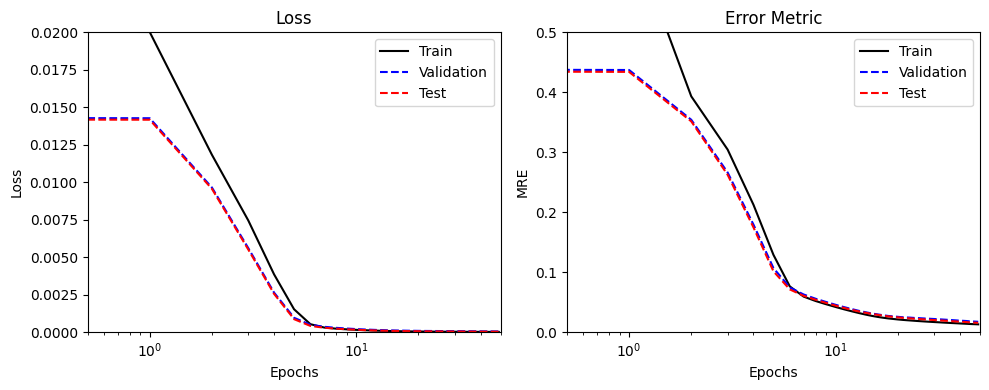

In [32]:
plot_errors(trainer, 0.02, 0.5)

In [33]:
xsens.shape, ygrid.shape

((50,), (1000,))

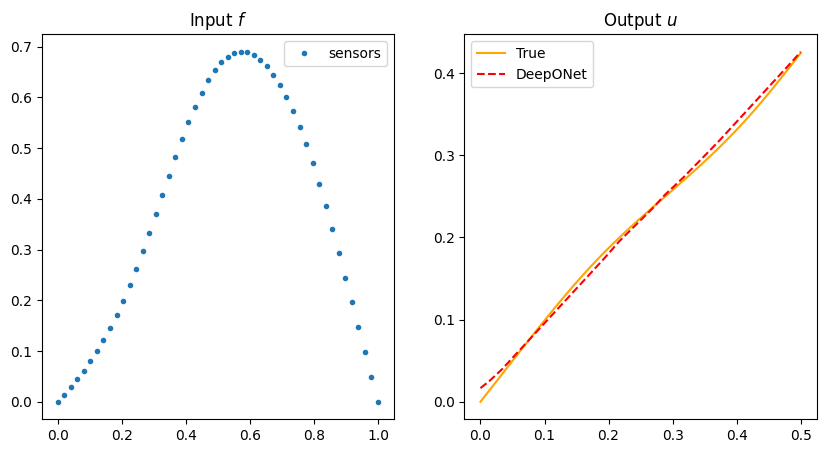

In [34]:
j = -7
compare_solutions_scalar(test_set[j])

In [35]:
print("MRE for DeepONet: %s." % num2p(trainer.train_hist['error_metric'][-1]))

MRE for DeepONet: 1.30%.


## 3. Darcy Flow
Today we consider a simplified Darcy flow model featuring a spatially distributed parameter (permeability field), namely

$$\begin{cases}-\nabla\cdot(k\nabla p) = f & \text{in}\;\Omega\\-\nabla p\cdot\boldsymbol{n}\equiv0 & \text{on}\;\partial\Omega\\\int_{\Omega}p=0\end{cases}$$

where $\Omega\subset\mathbb{R}^{2}$ is the spatial domain, $p:\Omega\to\mathbb{R}$ is the pressure field and $\boldsymbol{n}$ is the unit normal. The permeability field, $k:\Omega\to(0,+\infty)$ is our parameter. We model it using a random field for which

$$0.1\le k \le 10.1,\quad\quad k\in\mathcal{C}(\Omega),$$

holds $\mathbb{P}$-almost surely. Specifically, we derive the latter as

$$k = 10\mathcal{S}(D e^{-\gamma Z})+0.1$$

where

- $\gamma=1/4$,
- $D:\Omega\to[0,+\infty)$ is a deterministic map, related to the "point-to-boundary-distance",
- $Z$ is a centered Gaussian random field with isotropic covariance kernel $\kappa(r)=e^{-100r^2}$,
- $\mathcal{S}$ is a scaling operator. Precisely, if $g\in\mathcal{C}(\Omega)$ is nonconstant, then $\mathcal{S}(g)$ is defined as

$$\mathcal{S}(g):=\frac{g-\min_{\boldsymbol{x}\in\Omega}g(\boldsymbol{x})}{\max_{\boldsymbol{x}\in\Omega}g(\boldsymbol{x})-\min_{\boldsymbol{x}\in\Omega}g(\boldsymbol{x})}.$$

We are interested in learning the map

$$k\mapsto p,$$

that maps the permeability field onto the corresponding pressure field. Here, as a spatial domain $\Omega$ we consider the Elba Island. As a source term, instead, we consider a superposition of three pointwise sources (of fixed position and intensity),

$$f = \sum_{i=1}^{3}\delta_{\boldsymbol{x}_i},$$

where $\delta_{\boldsymbol{x}_i}$ denotes the Dirac delta at $\boldsymbol{x}_i$.

In [ ]:
k, pressure = load_data(id = "1Fx0BJbggyoFS344kEsl3M2QroLYg2Cp1")

Downloading...
From (original): https://drive.google.com/uc?id=1Fx0BJbggyoFS344kEsl3M2QroLYg2Cp1
From (redirected): https://drive.google.com/uc?id=1Fx0BJbggyoFS344kEsl3M2QroLYg2Cp1&confirm=t&uuid=f3c5dfb9-f0cf-4b57-8e1f-fe93c35ac8a2
To: /content/data.npz
100%|██████████| 153M/153M [00:02<00:00, 58.3MB/s]


In [ ]:
k.shape, pressure.shape

((1000, 9550), (1000, 9550))

In [ ]:
gdown.download(id = "16n2zKU9xjhO0LY5Ddeov0DXTfJaO4oV4", output = "elba_mesh.xml")
mesh = fe.loadmesh("elba_mesh.xml")
Vh, y = get_fem_space(mesh)

Downloading...
From (original): https://drive.google.com/uc?id=16n2zKU9xjhO0LY5Ddeov0DXTfJaO4oV4
From (redirected): https://drive.google.com/uc?id=16n2zKU9xjhO0LY5Ddeov0DXTfJaO4oV4&confirm=t&uuid=288f0d55-8ef1-4135-8967-ff75b8a503ec
To: /content/elba_mesh.xml
100%|██████████| 1.93M/1.93M [00:00<00:00, 65.2MB/s]


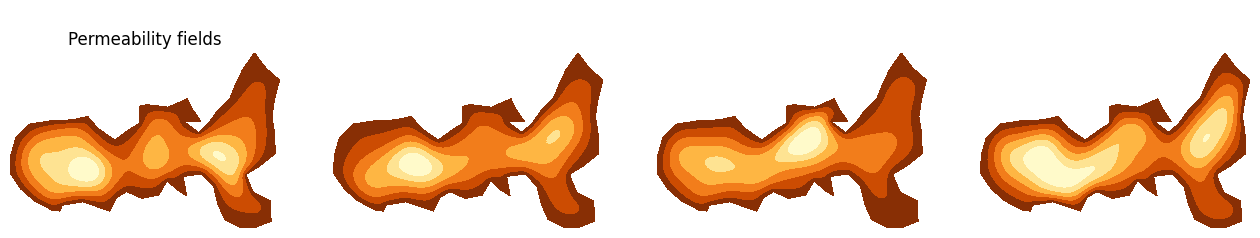

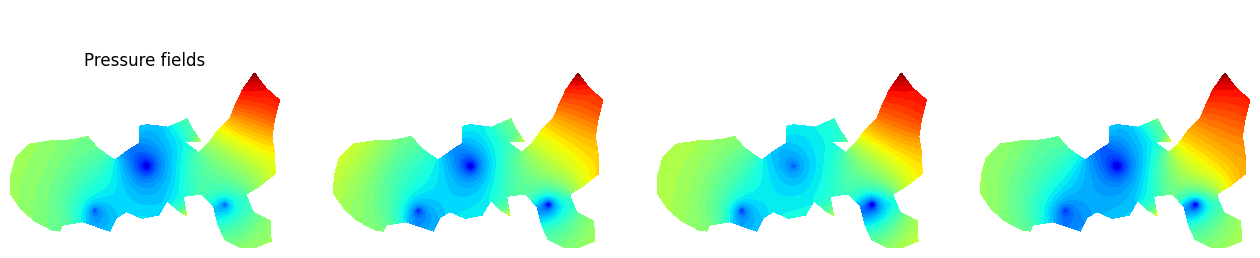

In [ ]:
fe.multiplot(k[:4], (1, 4), Vh, levels = 7, cmap = 'YlOrBr_r')
plt.subplot(1, 4, 1)
plt.title("\nPermeability fields")

fe.multiplot(pressure[:4], (1, 4), Vh, levels = 50)
plt.subplot(1, 4, 1)
plt.title("\n\nPressure fields")
None

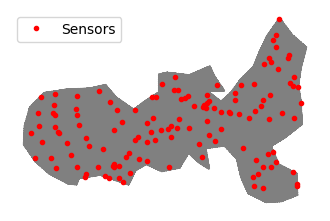

In [ ]:
# Define the sensor location
nsensors = 131
sensors = np.linspace(0, Vh.dim(), nsensors+1).astype('int')[:-1]
plt.figure(figsize = (4, 4))
fe.plot(mesh)
plt.plot(*fe.coordinates(Vh)[sensors].T, '.r', label = 'Sensors')
plt.legend()
plt.show()

In [ ]:
# Define the mesh
ymesh = dv.tensor(fe.coordinates(Vh))

# Sample the permeadbility field in the sensor location
ksens = k[:, sensors]

In [ ]:
ksens.shape, ymesh.shape

((1000, 131), torch.Size([9550, 2]))

In [ ]:
# Config
learning_rate = 1e-3
batch_size = 1
epochs = 50

m = nsensors
d = ymesh.shape[1]
p = 15
h = 100

In [ ]:
# Build the model
model = DeepONet(m,d,p,h)
model.to(device)
print(model)

DeepONet(
  (branch): Sequential(
    (0): Linear(in_features=131, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=100, out_features=15, bias=True)
  )
  (trunk): Sequential(
    (0): Linear(in_features=2, out_features=100, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=100, out_features=15, bias=True)
  )
)


In [ ]:
# Build the dataset
train_size = 800
val_size = 50

dataset = FomDataset(ksens, pressure, ymesh)
train_set, val_set, test_set = train_val_test_split(dataset, train_size, val_size)

train_loader = DataLoader(train_set, batch_size = batch_size)
val_loader = DataLoader(val_set, batch_size = batch_size)
test_loader =  DataLoader(test_set, batch_size = batch_size)

<ipython-input-5-67f152691133>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.y = torch.tensor(y, dtype=torch.float32)


In [ ]:
# Define loss function
loss_function = mse_loss
error_metric = error_metric

# Define optimization strategy
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [ ]:
# Train the model
trainer = Trainer(train_loader, val_loader, test_loader, model, loss_function, optimizer, epochs, error_metric)
train_hist, val_hist, test_hist = trainer.fit()

Epoch 1/50:
Current Loss: 0.066990  [  741/  750]
Train Loss: 0.0288 | Val Loss: 0.0146 | Test Loss: 0.0142
Epoch 2/50:
Current Loss: 0.057579  [  741/  750]
Train Loss: 0.0163 | Val Loss: 0.0128 | Test Loss: 0.0129
Epoch 3/50:
Current Loss: 0.055122  [  741/  750]
Train Loss: 0.0130 | Val Loss: 0.0110 | Test Loss: 0.0112
Epoch 4/50:
Current Loss: 0.035017  [  741/  750]
Train Loss: 0.0110 | Val Loss: 0.0088 | Test Loss: 0.0090
Epoch 5/50:
Current Loss: 0.023112  [  741/  750]
Train Loss: 0.0090 | Val Loss: 0.0079 | Test Loss: 0.0079
Epoch 6/50:
Current Loss: 0.019883  [  741/  750]
Train Loss: 0.0086 | Val Loss: 0.0068 | Test Loss: 0.0068
Epoch 7/50:
Current Loss: 0.018846  [  741/  750]
Train Loss: 0.0071 | Val Loss: 0.0066 | Test Loss: 0.0064
Epoch 8/50:
Current Loss: 0.015032  [  741/  750]
Train Loss: 0.0062 | Val Loss: 0.0056 | Test Loss: 0.0053
Epoch 9/50:
Current Loss: 0.009691  [  741/  750]
Train Loss: 0.0058 | Val Loss: 0.0056 | Test Loss: 0.0054
Epoch 10/50:
Current Loss: 0

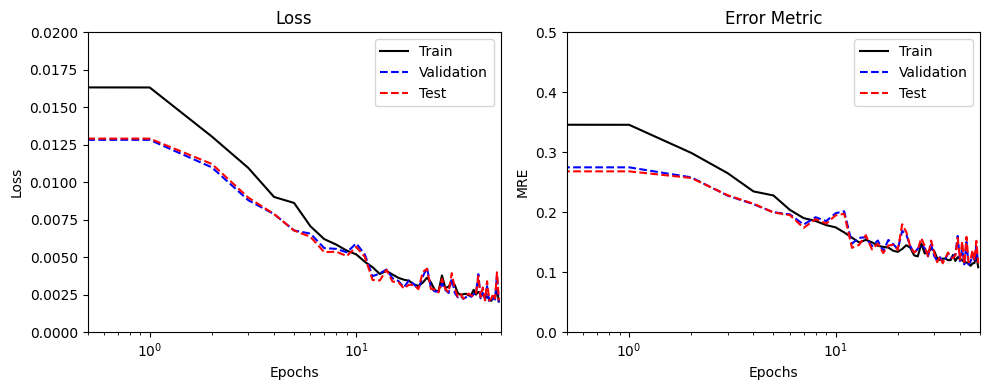

In [ ]:
plot_errors(trainer, 0.02, 0.5)

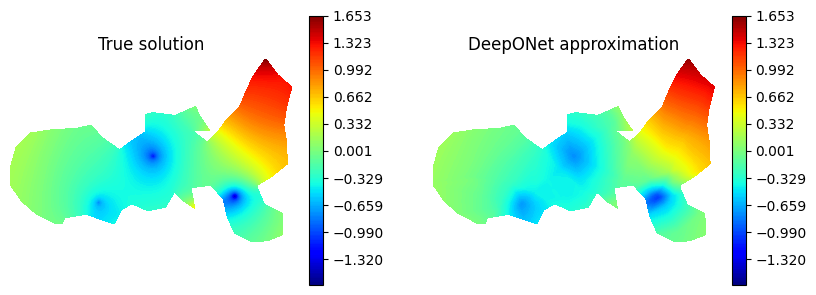

In [ ]:
j = -1
compare_solutions(test_set[j], Vh)